In [2]:
import json
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', None)  

In [2]:
#mf_survey = pd.read_pickle('../../data/moral-survey/moral-foundation-theory-responses-processed.pkl')
#users_morals = pd.Series(mf_survey['moral-scores'].values, index=mf_survey['Email Address']).to_dict()
#users_morals['fu4k6@email.com'] = users_morals['fu4k6@mail.com']

In [2]:
responses_df = pd.read_csv('../../data/moral-survey/moral-foundation-part2-responses.csv')
responses_df = responses_df.dropna()
responses_df['morals'] = responses_df['Email Address'].apply(lambda x: users_morals[x])

In [89]:
columns = responses_df.columns
topics = [x.split(' ')[0] for x in columns[2:-1]]

In [90]:
def reformat_data(responses_df):
    reformated_data = []
    for i, row in responses_df.iterrows():
        for topic in topics:
            reformated_data.append([row['Email Address'],
                                    row['morals'],
                                'pro' if 'pro' in topic else 'con',
                                topic, 
                                row["{} Rank the previous narrative according to their effectiveness: [Narrative-1]".format(topic)],
                                row["{} Rank the previous narrative according to their effectiveness: [Narrative-2]".format(topic)],
                                row["{} Rank the previous narrative according to their effectiveness: [Narrative-3]".format(topic)]
                            ])

    responses_df = pd.DataFrame(reformated_data, columns=['email', 'morals', 'stance', 'topic', 'narrative-1', 'narrative-2', 'narrative-3'])

    return responses_df

In [91]:
responses_df = reformat_data(responses_df)

In [92]:
#responses_df = responses_df[responses_df.email != 'milad.alshomary@uni-paderborn.de']

In [112]:
narrative_1 = responses_df['narrative-1'].tolist()
narrative_2 = responses_df['narrative-2'].tolist()
narrative_3 = responses_df['narrative-3'].tolist()

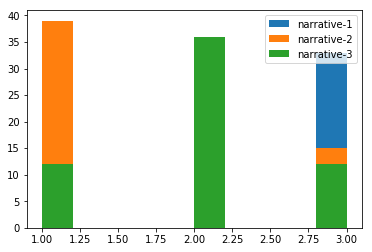

In [114]:
plt.hist(narrative_1, label='narrative-1', cumulative=False)
plt.hist(narrative_2, label='narrative-2', cumulative=False)
plt.hist(narrative_3, label='narrative-3', cumulative=False)
plt.legend()
plt.show()

--------

### Main Study Analysis:

In [87]:
from tabulate import tabulate

In [88]:
def maj_rank(ranks):
    max_rank = max(set(ranks), key=ranks.count)
    print(ranks)
    if ranks.count(max_rank) <= int(len(ranks)/2):
        print('returning -1')
        return -1
    else:
        return max_rank

def avg_rank(ranks):
    return np.mean(ranks)

def argument_ranks(df, aggregate=False):
    
    data = []
    for arg_type in ['binding', 'individual', 'general']:
        arg_type_df = df[df['arg-type'] == arg_type]
        
        if aggregate:
            ranks =  arg_type_df.groupby(['topic', 'arg_stance']).agg({
                'rank': lambda x: maj_rank(list(x))})['rank'].tolist()
        else:
            ranks = arg_type_df['rank'].tolist()
        
        f_rank = round(ranks.count(1) /len([x for x in ranks if x !=-1]), 2)
        s_rank = round(ranks.count(2)/len([x for x in ranks if x !=-1]), 2)
        l_rank = round(ranks.count(3)/len([x for x in ranks if x !=-1]), 2)
        agreement = round((len(ranks) - ranks.count(-1))/len(ranks), 2)
        
        avg_rank = round(np.mean(arg_type_df['rank'].tolist()), 2)
            
        data.append([arg_type, f_rank, s_rank, l_rank, avg_rank, agreement])
        
    print(tabulate(data, headers=['rank-1', 'rank-2', 'rank-3', 'avg-rank', 'agreement']))
        
def reformat_data(responses_df):
    arg_map = {
        'argument-1': 'binding',
        'argument-2': 'individual',
        'argument-3': 'general'
    }

    reformated_data = []
    for i, row in responses_df.iterrows():
        for topic in topics:
            if row['Username'] in users_ideology_map:
                topic_name = topic.replace('[', '').replace('pro-', '').replace('con-', '').replace(']', '')
                user_stance_key = [key for key in row.keys() if key.startswith("[stance-on-{}".format(topic_name))][0]

                for arg in ['argument-1', 'argument-2', 'argument-3']:
                    
                    reformated_data.append([row['Username'],
                                            users_ideology_map[row['Username']],
                                            int(row[user_stance_key][0]),
                                            'pro' if 'pro-' in topic else 'con',
                                            topic_name,
                                            arg_map[arg],
                                            row["{} Rank the previous arguments according to their effectiveness: [{}]".format(topic, arg)]
                                        ])
                
    responses_df = pd.DataFrame(reformated_data, columns=['email', 'ideology', 'user_stance', 'arg_stance', 'topic', 'arg-type', 'rank'])

    return responses_df

def same_stance(row):
    if row['user_stance'] == 3:
        return 'unk'
    
    if row['user_stance'] > 3 and row['arg_stance']=='pro':
        return 'same'
    
    if row['user_stance'] < 3 and row['arg_stance']=='con':
        return 'same'
    
    if row['user_stance'] < 3 and row['arg_stance']=='pro':
        return 'diff'
    
    if row['user_stance'] > 3 and row['arg_stance']=='con':
        return 'diff' 
    

In [89]:
users_ideology_map = {
    #'dominic.beccari@gmail.com': 'Liberal',
    'mpy2@aol.com': 'Liberal',
    'onnaday@onnaday.com': 'Liberal',
    'mollynm@gmail.com': 'Liberal',
    'faith.brandi@gmail.com': 'Conservative',
    'bret.thurman0129@gmail.com': 'Conservative',
    'mikestroup@suddenlink.net': 'Conservative'
}

In [90]:
main_df = pd.read_csv('../../data/moral-survey/moral-foundation-main-study.csv')

columns = main_df.columns
topics = set([x.split(' ')[0] for x in columns[12:]])

main_df = main_df.rename(columns={
    '[stance-on-legalizing-prostitution] Stance on Legalizing Prostitution?' : '[stance-on-legalized-prostitution] Stance on Legalizing Prostitution?'
})
main_df = reformat_data(main_df)
main_df['same_stance'] = main_df.apply(lambda row: same_stance(row), axis=1)

In [91]:
#main_df[main_df.email=='bret.thurman0129@gmail.com'].head(n=60)

In [92]:
main_df.email.value_counts()

mikestroup@suddenlink.net     60
mollynm@gmail.com             60
onnaday@onnaday.com           60
faith.brandi@gmail.com        60
bret.thurman0129@gmail.com    60
mpy2@aol.com                  60
Name: email, dtype: int64

In [93]:
main_df.ideology.value_counts()

Conservative    180
Liberal         180
Name: ideology, dtype: int64

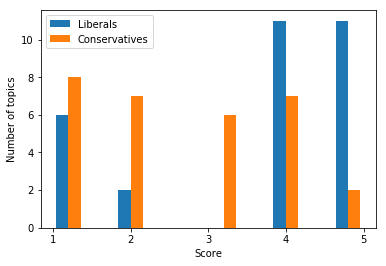

In [94]:
lib_count = main_df[(main_df.ideology=='Liberal')].groupby(['topic', 'email']).agg({'user_stance': lambda x : list(x)[0]})['user_stance'].tolist()
con_count = main_df[(main_df.ideology=='Conservative')].groupby(['topic', 'email']).agg({'user_stance': lambda x : list(x)[0]})['user_stance'].tolist()
plt.hist([lib_count, con_count], label=['Liberals', 'Conservatives'])
plt.legend()
plt.xticks([1,2,3,4,5])
plt.xlabel('Score')
plt.ylabel('Number of topics')
plt.savefig('stance_dist.pdf')  
plt.show()

### Annotator's agreement:

In [19]:
from scipy.stats import kendalltau

In [20]:
main_df.groupby(['topic', 'arg_stance', 'ideology', 'arg-type']).agg({
                'rank': lambda x: list(x)})['rank'].reset_index()

,topic,arg_stance,ideology,arg-type,rank
0,affirmative-actions,con,Conservative,binding,"[2, 3, 3]"
1,affirmative-actions,con,Conservative,general,"[3, 2, 2]"
2,affirmative-actions,con,Conservative,individual,"[1, 1, 1]"
3,affirmative-actions,con,Liberal,binding,"[2, 3, 1]"
4,affirmative-actions,con,Liberal,general,"[3, 2, 3]"
5,affirmative-actions,con,Liberal,individual,"[1, 1, 2]"
6,affirmative-actions,pro,Conservative,binding,"[2, 2, 2]"
7,affirmative-actions,pro,Conservative,general,"[3, 3, 3]"
8,affirmative-actions,pro,Conservative,individual,"[1, 1, 1]"
9,affirmative-actions,pro,Liberal,binding,"[2, 1, 3]"


In [21]:
def compute_kendalls(df):
    
    ranks =  df.groupby(['topic', 'stance']).agg({
                'rank': lambda x: list(x)})['rank'].reset_index()
    
    scores = []
    for row in df.iterr
    kendalltau(r1, r2)[0]

SyntaxError: invalid syntax (<ipython-input-21-ed7a2094b124>, line 7)

#### All results:

Here we consider all users regardless of their political ideology. This mean each instance (ranking 3 arguments) was evaluated
by six annotators.

- Taking individual judgements:

In [96]:
argument_ranks(main_df, aggregate=False)

              rank-1    rank-2    rank-3    avg-rank    agreement
----------  --------  --------  --------  ----------  -----------
binding         0.24      0.32      0.44        2.2             1
individual      0.45      0.38      0.17        1.72            1
general         0.31      0.3       0.39        2.08            1


- Taking the majority rank from the six annotator:

In [102]:
argument_ranks(main_df, aggregate=False)

              rank-1    rank-2    rank-3    avg-rank    agreement
----------  --------  --------  --------  ----------  -----------
binding         0.24      0.32      0.44        2.2             1
individual      0.45      0.38      0.17        1.72            1
general         0.31      0.3       0.39        2.08            1


- In general, morally framed arguments showed to be more effective than general arguments.
- In general, arguments focusing on the individual morals, are best ranked.

#### A look at the liberals:

In [55]:
lib_df = main_df[main_df.ideology == 'Liberal']

- Results show that Liberals ranked binding-arguments more effective than the individual and general arguments (if we consdier both rank-1 and rank-2 against rank-3).

In [56]:
argument_ranks(lib_df, aggregate=False)

              rank-1    rank-2    rank-3    avg-rank    agreement
----------  --------  --------  --------  ----------  -----------
binding         0.23      0.37       0.4        2.17            1
individual      0.4       0.4        0.2        1.8             1
general         0.37      0.23       0.4        2.03            1


In [57]:
argument_ranks(lib_df, aggregate=True)

[2, 3, 1]
returning -1
[2, 1, 3]
returning -1
[3, 2, 3]
[3, 2, 2]
[3, 2, 2]
[2, 3, 2]
[1, 3, 2]
returning -1
[3, 3, 3]
[2, 2, 3]
[3, 2, 3]
[1, 2, 3]
returning -1
[2, 3, 3]
[2, 3, 3]
[2, 1, 3]
returning -1
[2, 1, 3]
returning -1
[1, 1, 3]
[1, 1, 1]
[1, 3, 2]
returning -1
[1, 2, 2]
[1, 2, 3]
returning -1
[1, 1, 2]
[3, 2, 1]
returning -1
[1, 3, 2]
returning -1
[2, 3, 1]
returning -1
[1, 1, 1]
[3, 2, 1]
returning -1
[2, 1, 1]
[2, 2, 2]
[3, 1, 2]
returning -1
[2, 3, 1]
returning -1
[2, 1, 1]
[1, 1, 2]
[1, 1, 2]
[1, 3, 2]
returning -1
[1, 3, 2]
returning -1
[2, 2, 2]
[2, 2, 2]
[3, 2, 1]
returning -1
[3, 1, 1]
[3, 3, 2]
[3, 2, 3]
[1, 3, 2]
returning -1
[2, 1, 1]
[1, 1, 3]
[2, 3, 3]
[1, 1, 3]
[3, 2, 3]
[1, 1, 1]
[1, 3, 1]
[1, 1, 2]
[3, 3, 2]
[3, 2, 1]
returning -1
[3, 2, 1]
returning -1
[3, 2, 1]
returning -1
[3, 2, 1]
returning -1
[3, 3, 1]
[3, 3, 3]
[2, 1, 3]
returning -1
[2, 3, 3]
[2, 1, 1]
              rank-1    rank-2    rank-3    avg-rank    agreement
----------  --------  --------  ---

Now lets invistigate how effectiveness differs if the annotators have the same stance or opposing stance to the provided arguments:

- Liberals were decisive with their stance. They were always either pro or con, but not no-stance.

In [58]:
lib_df[lib_df['arg-type']=='binding']['same_stance'].value_counts()

same    30
diff    30
Name: same_stance, dtype: int64

In [60]:
argument_ranks(lib_df[lib_df['same_stance']=='same'], aggregate=False)

              rank-1    rank-2    rank-3    avg-rank    agreement
----------  --------  --------  --------  ----------  -----------
binding         0.2       0.33      0.47        2.27            1
individual      0.37      0.43      0.2         1.83            1
general         0.43      0.23      0.33        1.9             1


- When arguments have different stance to the liberals, arguments focusing on their morals (individual-arguments) becamse more effective? (Weak signal)

In [61]:
argument_ranks(lib_df[lib_df['same_stance']=='diff'], aggregate=False)

              rank-1    rank-2    rank-3    avg-rank    agreement
----------  --------  --------  --------  ----------  -----------
binding         0.27      0.4       0.33        2.07            1
individual      0.43      0.37      0.2         1.77            1
general         0.3       0.23      0.47        2.17            1


#### A look at the Concervatives:

In [97]:
con_df = main_df[main_df.ideology == 'Conservative']
#con_df = con_df[con_df.user_stance != 3]

- Results show that Conservatives ranked individual-arguments more effective than the binding and general arguments.
- Conservatives seem to be more affected by moral-arguments

In [98]:
argument_ranks(con_df)

              rank-1    rank-2    rank-3    avg-rank    agreement
----------  --------  --------  --------  ----------  -----------
binding         0.25      0.27      0.48        2.23            1
individual      0.5       0.37      0.13        1.63            1
general         0.25      0.37      0.38        2.13            1


Now lets invistigate how effectiveness differs if the annotators have the same stance or opposing stance to the provided arguments:

In [99]:
con_df[con_df['arg-type']=='binding']['same_stance'].value_counts()

same    24
diff    24
unk     12
Name: same_stance, dtype: int64

In [100]:
argument_ranks(con_df[con_df['same_stance']=='same'], aggregate=False)

              rank-1    rank-2    rank-3    avg-rank    agreement
----------  --------  --------  --------  ----------  -----------
binding         0.25      0.21      0.54        2.29            1
individual      0.5       0.29      0.21        1.71            1
general         0.25      0.5       0.25        2               1


In [101]:
argument_ranks(con_df[con_df['same_stance'] == 'diff'], aggregate=False)

              rank-1    rank-2    rank-3    avg-rank    agreement
----------  --------  --------  --------  ----------  -----------
binding         0.17      0.21      0.62        2.46            1
individual      0.5       0.46      0.04        1.54            1
general         0.33      0.33      0.33        2               1


In [102]:
argument_ranks(con_df[con_df['same_stance']=='unk'], aggregate=False)

              rank-1    rank-2    rank-3    avg-rank    agreement
----------  --------  --------  --------  ----------  -----------
binding         0.42      0.5       0.08        1.67            1
individual      0.5       0.33      0.17        1.67            1
general         0.08      0.17      0.75        2.67            1


In [107]:
argument_ranks(con_df[con_df['same_stance']!='same'], aggregate=False)

              rank-1    rank-2    rank-3    avg-rank    agreement
----------  --------  --------  --------  ----------  -----------
binding         0.25      0.31      0.44        2.19            1
individual      0.5       0.42      0.08        1.58            1
general         0.25      0.28      0.47        2.22            1


-------

#### Follow-up quesionnaire:

In [3]:
df = pd.read_csv('../../data/moral-survey/moral-foundation-followup-questionnaire.csv')

FileNotFoundError: [Errno 2] No such file or directory: '../../data/moral-survey/moral-foundation-followup-questionnaire.csv'

In [96]:
df.head(n=10)

,Timestamp,Email Address,"YOUR VIEWS: When arguments contested your stance on the topic, which of the following arguments did you see as more effective:","YOUR KNOWLEDGE: When arguments contested your stance on the topic, which of the following arguments did you see as more effective","OTHERS' VIEWS: When arguments contested your stance on the topic, which of the following arguments did you see as more effective","When arguments contested your stance on the topic, which of the above three was most important for you to judge about effectiveness:","YOUR VIEWS: When arguments had similar stance to yours, which of the following arguments did you see as more effective:","YOUR KNOWLEDGE: When arguments has similar stance to yours, which of the following arguments did you see as more effective","OTHERS' VIEWS: When arguments had similar stance to yours, which of the following arguments did you see as more effective","When arguments had similar stance to yours, which of the above three was most important for you to judge about effectiveness:",Are there are other important factors that influenced your judgment of the effectiveness:
0,7/21/2021 22:38:42,bret.thurman0129@gmail.com,Arguments that challenged your views,Arguments that introduce views you were not fa...,Neither of those was important,Others' views,Arguments that challenged your views,Arguments that introduce views you were not fa...,Arguments you saw as particularly convincing t...,Others' views,NaN
1,7/21/2021 23:22:52,onnaday@onnaday.com,Neither of those was important,Arguments that introduce views you were not fa...,Arguments you saw as particularly convincing t...,Your knowledge,Arguments that matched your views,Arguments that introduce views you were not fa...,Arguments you saw as particularly convincing t...,Your knowledge,One's presentation of their views is something...
2,7/22/2021 1:16:07,mollynm@gmail.com,Neither of those was important,Arguments that introduce views you were not fa...,Arguments you saw as particularly convincing t...,Others' views,Arguments that matched your views,Arguments based on views you already knew about,Arguments you saw as particularly convincing t...,Your knowledge,Some other factors that influenced my judgemen...
3,7/22/2021 7:55:45,faith.brandi@gmail.com,Arguments that challenged your views,Arguments that introduce views you were not fa...,Arguments you saw as particularly convincing t...,Your knowledge,Arguments that matched your views,Arguments based on views you already knew about,Arguments you saw as particularly convincing t...,Your knowledge,Arguments that were free from grammatical erro...
4,7/23/2021 16:06:31,mikestroup@suddenlink.net,Arguments that challenged your views,Neither of those was important,Neither of those was important,Your knowledge,Neither of those was important,Arguments that introduce views you were not fa...,Neither of those was important,Your knowledge,Verifiable acts and logical arguments speak mu...
5,7/25/2021 0:56:09,mpy2@aol.com,Arguments that matched your views,Arguments that introduce views you were not fa...,Arguments you saw as particularly convincing t...,Your knowledge,Arguments that challenged your views,Arguments that introduce views you were not fa...,Arguments you saw as particularly convincing t...,Your knowledge,pertinent evidence and actual consequences


In [18]:
for clm in df.columns[2:-1]:
    print(clm)
    print(df[clm].value_counts().to_dict())
    print('==============')
    print()

YOUR VIEWS: When arguments contested your stance on the topic, which of the following arguments did you see as more effective:
{'Arguments that challenged your views': 3, 'Neither of those was important': 2, 'Arguments that matched your views': 1}

YOUR KNOWLEDGE: When arguments contested your stance on the topic, which of the following arguments did you see as more effective
{'Arguments that introduce views you were not familiar with': 5, 'Neither of those was important': 1}

OTHERS' VIEWS: When arguments contested your stance on the topic, which of the following arguments did you see as more effective
{'Arguments you saw as particularly convincing to people that rather oppose your views': 4, 'Neither of those was important': 2}

When arguments contested your stance on the topic, which of the above three was most important for you to judge about effectiveness:
{'Your knowledge': 4, "Others' views": 2}

YOUR VIEWS: When arguments had similar stance to yours, which of the following argu